### User Inputs

In [1]:
retailer = 'pure'
sql = 'pure_txns.sql'
offer_name = 'free coffee yellow'
measurement_period = ''

### Packages and definitions needed for python 

In [2]:
# install required packages
import pandas as pd
import numpy as np
from utils.database import query_from_file
import datetime
import time
import plotly.express as px
import psutil
from datetime import datetime, timedelta
from utils import style
import matplotlib
path = '/Users/jennamiles/Documents/credentials'

/Users/jennamiles/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

In [39]:
matplotlib.rcParams['font.sans-serif'] = 'Akkurat Pro'
matplotlib.rcParams['font.serif'] = 'Vesterbro'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = '15'

matplotlib.rcParams['figure.figsize'] = (50, 15)
matplotlib.rcParams['figure.titlesize'] = '25'

matplotlib.rcParams['axes.titlesize'] = '25'
matplotlib.rcParams['axes.labelsize'] = '15'
matplotlib.rcParams['axes.titlepad'] = '25'
matplotlib.rcParams['axes.labelpad'] = '30'
matplotlib.rcParams['xtick.labelsize'] = '15'
matplotlib.rcParams['ytick.labelsize'] = '20'

### Read in transactions for retailer

In [5]:
#read in pure data from SQL query:
start = time.time()
df = query_from_file(sql)
end = time.time()
query_time = end-start
print(f"Query took {query_time:.2f} seconds")

Query took 8.99 seconds


### Data pre-processing
- Creates new **date** variables that will be useful

In [6]:
#additional date columns that will be useful 
df['date'] = df['transaction_date'].dt.date
df['day'] = df['transaction_date'].dt.isocalendar().day
df['week'] = df['transaction_date'].dt.isocalendar().week
df['week_start'] = (df['transaction_date'] - pd.TimedeltaIndex(df['transaction_date'].dt.dayofweek, unit='D')).dt.date
df['month'] = df['transaction_date'].dt.month

- Change data types where necessary

In [7]:
#change price to a numeric variable 
df['price'] = pd.to_numeric(df['item_price'])

- Creates a variable that indicates the **receipt number** for that customer
- This will be used to segments new and existing customers
- Warning - we can only see if they are new customers within Flux, so they may have a receipt count of 1 even though transacted before 

In [8]:
df_receipts = df[['customer_id','receipt_id','total_amount','transaction_date','date','month','week','location_id']].drop_duplicates().sort_values(['customer_id','transaction_date'])
df_receipts['receipt_count'] = df_receipts.groupby(['customer_id'])['receipt_id'].cumcount()+1
df = pd.merge(df, df_receipts[['receipt_count','customer_id','receipt_id']], on = ['customer_id','receipt_id'], how = 'left' )

- identify transactions on the chosen offer
- save the receipts containing the offer to an array to reference another time

In [9]:
df_offer = df[df['name'].str.lower() == offer_name].copy()
redemption_receipts = df_offer['receipt_id'].unique()
redeemers = df_offer['customer_id'].unique()
redemption_count = len(redemption_receipts)
redeemer_count = len(redeemers)

- assign start and end dates of the offer to objects to reference in code
- assign the number of days, weeks and months an offer was live for to objects to reference in code

In [10]:
date_min = df_offer['date'].min()
date_max = df_offer['date'].max()
days_live = (date_max - date_min).days
weeks_live = round(np.floor(days_live/7))
months_live = round(np.floor(weeks_live/4))

- identify all transactions at retailer while the offer was live
- segment customers that transacted during the offer period into customers acquired on offer and previous customers = acquired_previous
- segment customers that transacted into new and existing before the offer period start date = new_existing
- segment customers into customers that redeemed the offer or not
- also going to provide a view of acquired, new_not_acquired, existing

In [11]:
df_live = df[(df['date']<=date_max) & (df['date']>=date_min)].copy()

new_customers = df_live[df_live.receipt_count== 1].customer_id.unique()
acquired_customers = df_live[(df_live['receipt_id'].isin(redemption_receipts))& (df_live.receipt_count==1)]['customer_id'].unique()

df_live['redemption_segment'] = np.where(df_live['customer_id'].isin(redeemers),'redeemer','non-redeemer')
df_live['acquired_previous'] = np.where(df_live['customer_id'].isin(acquired_customers),'acquired','previous')
df_live['new_existing'] = np.where(df_live['customer_id'].isin(new_customers),'new','existing')
df_live['acquired_new_existing'] = np.where(df_live['customer_id'].isin(acquired_customers),'acquired',df_live['new_existing'])
df_live['acquired_new_existing'] = df_live['acquired_new_existing'].str.replace('new','new_not_acquired')

- create a df that holds only the receipt information and not the sku data too, with segments included

In [12]:
df_live_receipts = df_live[['customer_id', 'receipt_id', 'total_amount', 'price', 'redemption_segment', 'acquired_previous', 'new_existing', 'acquired_new_existing','transaction_date','receipt_count','date','week_start']].copy().drop_duplicates()

- add in a variable that holds **basket size**
- don't want to include in basket size any freebies or £0 items, such as the milk chosen, or any discounts that aren't an item, such as 50p off for using a reusable cup
- it is tricky because the true offers, such as free coffe first appear as an item and then the price is taken off. 
- The item price being taken off should match that provided on the receipt for it to be an offer and not just a discounts, e.g. reusable cup 50p

In [13]:
# add a receipt_price_count variable, so can flag if multiple used on one receipt
df['receipt_price_count'] = df.groupby(['receipt_id','price']).cumcount()+1
#identify the discounts
discounts = pd.DataFrame(df[df['price']<0][['receipt_id','price','receipt_price_count']])
discounts['price'] = discounts['price']*-1
discounts['offer_flag'] = '1'
#reattach the discounts onto transactions to match the item where freebie has been given
#now anything bought on an offer should be flagged 
df = pd.merge(df, discounts, on=['receipt_id','price','receipt_price_count'], how = 'left')
df.fillna('0', inplace = True)
#count the paid-for items on each receipt
#this will still include the initial proe of items that were taken off the final receipt
receipt_item_count = pd.DataFrame(df[(df['price']>0) & (df['offer_flag']=='0')].groupby('receipt_id').count()['item_id']).reset_index()
receipt_item_count.columns = ['receipt_id','adjusted_basket_size']
#attach onto receipts from the offer period
df_live = pd.merge(df_live,receipt_item_count, on = 'receipt_id',how = 'left') 
df_live.fillna(0, inplace = True)

# Results
### Segment counts

In [14]:
customer_receipt_counts = df_live.groupby(['redemption_segment','acquired_previous','new_existing']).nunique()[['customer_id','receipt_id']]
customer_receipt_counts.columns = ['unique customers','unique receipts']
customer_receipt_counts

unique customers  \
redemption_segment acquired_previous new_existing                     
non-redeemer       previous          existing                  3134   
                                     new                       3896   
redeemer           acquired          new                         22   
                   previous          existing                    91   
                                     new                         44   

                                                   unique receipts  
redemption_segment acquired_previous new_existing                   
non-redeemer       previous          existing                13922  
                                     new                      6741  
redeemer           acquired          new                        54  
                   previous          existing                 1229  
                                     new                       488

### Segment percentages

- What percent of customers using the offer are acquired customers vs customers that had already transacted at the retailer?

In [15]:
customer_pcent = (customer_receipt_counts.loc['redeemer']['unique customers']/(customer_receipt_counts.loc['redeemer']['unique customers'].sum()))*100
print('The % split of redeemers by customer segment is:')
print(customer_pcent)

The % split of redeemers by customer segment is:
acquired_previous  new_existing
acquired           new             14.012739
previous           existing        57.961783
                   new             28.025478
Name: unique customers, dtype: float64


- what % of customers transacting per week at the retailer are new that week vs previous?
- use the previous 4 weeks worth of transactions prior to the offer
- we will use this as a baseline to compare the offer to

In [16]:
df_pre = df_receipts[df_receipts.date < date_min].copy()
baseline_pre = df_pre[df_pre['receipt_count']==1].groupby(['week','receipt_count']).nunique()[['customer_id']]/df_pre.groupby('week').nunique()[['customer_id']].tail(4)
baseline_new_pcent = baseline_pre['customer_id'].mean()*100
print(f'The baseline of transacting customers that are new per week is: {baseline_new_pcent:.2f}%')

The baseline of transacting customers that are new per week is: 51.63%


- *would be good here to know how much this varies - does the offer fall between 2sd of the ussual % customers? Is is truly different? or do we only care about having a comparison?*
- *or some sort of significance test*

In [17]:
#grab counts, ATF, ATV  and Basket Size per group 

#first group by customer
agg = df_live.groupby(['redemption_segment','acquired_previous','new_existing','customer_id']).agg({'receipt_id':['nunique']
                                                                                        ,'total_amount':['sum','mean']
                                                                                        ,'adjusted_basket_size':['mean']})
agg.columns=agg.columns.map('_'.join)
agg.columns = ['frequency','total_amount','amount','adjusted_basket_size']
agg.reset_index(inplace = True)
#then grab metrics
agg2 = agg.groupby(['redemption_segment','acquired_previous','new_existing']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'adjusted_basket_size':['mean','median']
                                                                           })
agg2.columns=agg2.columns.map('_'.join)
agg2['weekly_ATF'] = agg2['frequency_median']/(days_live/7)
agg2['yearly_ATF'] = (agg2['frequency_median']/(days_live))*365
agg2['ATF_offer_period'] = agg2['frequency_median']
agg2['ATV'] = agg2['amount_median']/100 #using median as less sensitive to outliers
agg2['weekly_ACV'] = (agg2['total_amount_median']/(days_live/7))/100
agg2['ACV_offer_period'] = (agg2['total_amount_median'])/100
agg2['ABS'] = agg2['adjusted_basket_size_median']
summary_metrics = agg2[['customer_id_nunique','weekly_ATF','ATF_offer_period','ATV','weekly_ACV','ACV_offer_period','ABS','yearly_ATF']]
summary_metrics
#note haven't separated out the custoomers acquired ON the offer here
#treating new customers during offer measurement period as all new even iff not acquired on the offer
#this is easier to measure
#just need to make sure it is clesar when displaying

customer_id_nunique  \
redemption_segment acquired_previous new_existing                        
non-redeemer       previous          existing                     3134   
                                     new                          3896   
redeemer           acquired          new                            22   
                   previous          existing                       91   
                                     new                            44   

                                                   weekly_ATF  \
redemption_segment acquired_previous new_existing               
non-redeemer       previous          existing        0.029167   
                                     new             0.014583   
redeemer           acquired          new             0.021875   
                   previous          existing        0.131250   
                                     new             0.087500   

                                                   ATF_offer_period       ATV  \
redemption_segment acquired_previous new_existing                               
non-redeemer       previous          existing                   2.0  5.118333   
                                     new                        1.0  4.950000   
redeemer           acquired          new                        1.5  3.411000   
                   previous          existing                   9.0  4.550000   
                                     new                        6.0  5.074308   

                                                   weekly_ACV  \
redemption_segment acquired_previous new_existing               
non-redeemer       previous          existing        0.252219   
                                     new             0.129573   
redeemer           acquired          new             0.280875   
                   previous          existing        0.926042   
                                     new             1.188031   

                                                   ACV_offer_period       ABS  \
redemption_segment acquired_previous new_existing                               
non-redeemer       previous          existing                17.295  1.500000   
                                     new                      8.885  1.000000   
redeemer           acquired          new                     19.260  1.000000   
                   previous          existing                63.500  1.470588   
                                     new                     81.465  1.650433   

                                                   yearly_ATF  
redemption_segment acquired_previous new_existing              
non-redeemer       previous          existing        1.520833  
                                     new             0.760417  
redeemer           acquired          new             1.140625  
                   previous          existing        6.843750  
                                     new             4.562500

In [86]:
agg2.loc['redeemer']

customer_id_nunique  frequency_mean  \
acquired_previous new_existing                                        
acquired          new                            22        2.454545   
previous          existing                       91       13.505495   
                  new                            44       11.090909   

                                frequency_median  total_amount_sum  \
acquired_previous new_existing                                       
acquired          new                        1.5           72057.0   
previous          existing                   9.0         1212964.0   
                  new                        6.0          556471.0   

                                total_amount_mean  total_amount_median  \
acquired_previous new_existing                                           
acquired          new                 3275.318182               1926.0   
previous          existing           13329.274725               6350.0   
                  new                12647.068182               8146.5   

                                amount_mean  amount_median  \
acquired_previous new_existing                               
acquired          new            456.089064     341.100000   
previous          existing       461.494134     455.000000   
                  new            525.421977     507.430761   

                                adjusted_basket_size_mean  \
acquired_previous new_existing                              
acquired          new                            1.446645   
previous          existing                       1.533120   
                  new                            1.769577   

                                adjusted_basket_size_median  weekly_ATF  \
acquired_previous new_existing                                            
acquired          new                              1.000000    0.021875   
previous          existing                         1.470588    0.131250   
                  new                              1.650433    0.087500   

                                yearly_ATF  ATF_offer_period       ATV  \
acquired_previous new_existing                                           
acquired          new             1.140625               1.5  3.411000   
previous          existing        6.843750               9.0  4.550000   
                  new             4.562500               6.0  5.074308   

                                weekly_ACV  ACV_offer_period       ABS  
acquired_previous new_existing                                          
acquired          new             0.280875            19.260  1.000000  
previous          existing        0.926042            63.500  1.470588  
                  new             1.188031            81.465  1.650433

## Redemptions Card

In [90]:
#all redemptions
total_redemptions = len(df_offer)
#all redeemers
total_cust = agg2.loc['redeemer'].customer_id_nunique.sum()
#all transactors:
total_transactors = agg2.customer_id_nunique.sum()
#redemptions per customer
redemptions_per_customer = total_redemptions/total_cust

#previous retailer customers
previous_volume = agg2.loc['redeemer'].loc['previous'].customer_id_nunique.sum()
#retailer acquisitions - made first transacgion on the offer
acquisitions_volume = agg2.loc['redeemer'].loc['acquired'].customer_id_nunique.sum()

#total new customers
new_volume = agg2.reset_index(['acquired_previous','redemption_segment']).loc['new'].customer_id_nunique.sum()
#total new redeemers
new_redeemers = agg2.loc['redeemer'].reset_index('acquired_previous').loc['new'].customer_id_nunique.sum()

#percentages
previous_pcent = (previous_volume/total_cust)*100
acquisitions_pcent = (acquisitions_volume/total_cust)*100
new_pcent = (new_volume/total_transactors)*100
baseline_diff = new_pcent - baseline_new_pcent

#print results
print(f'The total number of redemptions =  {total_redemptions}')
print(f'The total number of unique customers that used the offer = {total_cust}')
print(f'The numer of redemptions per customer = {redemptions_per_customer:.2f}')
print('\n')
print(f'{acquisitions_pcent:.0f}% of redeemers ({acquisitions_volume} customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer')
print(f'{previous_pcent:.0f}% of redeemers are previous customers')
print('\n')
print(f'The baseline % of weekly new customers is {baseline_new_pcent:.2f}% \n(This is the average % of customers that are new based on 4 weeks pre offer start)')
print(f'The % of weekly new customers during the offer period is {new_pcent:.2f}% ')
print('\n')
print(f'The offer period has an absolute % difference of {baseline_diff:.0f}% new customers compared to the baseline')

The total number of redemptions =  308
The total number of unique customers that used the offer = 157
The numer of redemptions per customer = 1.96


14% of redeemers (22 customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer
86% of redeemers are previous customers


The baseline % of weekly new customers is 51.63% 
(This is the average % of customers that are new based on 4 weeks pre offer start)
The % of weekly new customers during the offer period is 55.13% 


The offer period has an absolute % difference of 3% new customers compared to the baseline


## Frequency Metrics

In [91]:
f_metrics = summary_metrics['weekly_ATF']

#we want ot aggreate just for redemption segment
#using median so that result is insensitive to outlier customers
ATF_redeemer = agg[agg['redemption_segment']=='redeemer']['frequency'].median()
ATF_non_redeemer = agg[agg['redemption_segment']=='non-redeemer']['frequency'].median()

ATF_redeemer_weekly = agg[agg['redemption_segment']=='redeemer']['frequency'].median()/(days_live/7)
ATF_non_redeemer_weekly = agg[agg['redemption_segment']=='non-redeemer']['frequency'].median()/(days_live/7)

print(f'Redeemers of the offer transacted on average {ATF_redeemer:.2f} times during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer:.2f} times during the offer period')
print('\n')
print(f'Redeemers of the offer transacted on average {ATF_redeemer_weekly:.3f} times PER WEEK during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer_weekly:.3f} times PER WEEK during the offer period')
print('\n')
print(f'Redeemers of the offer transacted on average {ATF_redeemer_weekly*52:.1f} times over a projected year')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer_weekly*52:.1f} times over a projected year')
print('\n')
print('More detailed breakdown of weekly ATF:')
print(f_metrics)
print('\n')

Redeemers of the offer transacted on average 6.00 times during the offer period
Non-redeemers of the offer transacted on average 1.00 times during the offer period


Redeemers of the offer transacted on average 0.088 times PER WEEK during the offer period
Non-redeemers of the offer transacted on average 0.015 times PER WEEK during the offer period


Redeemers of the offer transacted on average 4.6 times over a projected year
Non-redeemers of the offer transacted on average 0.8 times over a projected year


More detailed breakdown of weekly ATF:
redemption_segment  acquired_previous  new_existing
non-redeemer        previous           existing        0.029167
                                       new             0.014583
redeemer            acquired           new             0.021875
                    previous           existing        0.131250
                                       new             0.087500
Name: weekly_ATF, dtype: float64




## Retention graph

- Want to look at acquisitions vs those that are new in the time period to compare the repeat purcahse rate
- Give view of how many made repeat purcahses

In [21]:
#grab the customers in two segments:
df_repeat_subset = df_live[df_live.new_existing == 'new'][['acquired_previous','customer_id','date','receipt_count']].copy()
#acquisitions
df_repeat_subset['lagged_date'] = df_repeat_subset.sort_values(by = ['customer_id','date'],ascending = True).groupby('customer_id')['date'].shift(1)
df_repeat_subset['date_diff'] = (df_repeat_subset['date'] - df_repeat_subset['lagged_date']).dt.days
df_repeat_subset['week_diff'] = np.ceil(df_repeat_subset.date_diff/7)

- over 12 weeks what % of acquired vs new not acquired made repeat purcahses?
- volumes:

In [22]:
#restrict to 12 weeks after their first transaction
df_repeat = df_repeat_subset[df_repeat_subset['week_diff']<12].groupby(['acquired_previous','receipt_count']).nunique()['customer_id'].unstack()
df_repeat[[1,2,3,4,5,6,7,8,9,10]].fillna(0)

receipt_count,1,2,3,4,5,6,7,8,9,10
acquired_previous,,,,,,,,,,
acquired,22.0,11.0,7.0,4.0,4.0,2.0,2.0,1.0,1.0,0.0
previous,1775.0,990.0,525.0,328.0,222.0,170.0,127.0,95.0,81.0,70.0


- as a percentage of those in each group:

In [23]:
df_repeat.div(df_repeat[1], axis=0)[[1,2,3,4,5,6,7,8,9,10]].fillna(0)*100


receipt_count,1,2,3,4,5,6,7,8,9,10
acquired_previous,,,,,,,,,,
acquired,100.0,50.000000,31.818182,18.181818,18.181818,9.090909,9.090909,4.545455,4.545455,0.000000
previous,100.0,55.774648,29.577465,18.478873,12.507042,9.577465,7.154930,5.352113,4.563380,3.943662


## Revenue Impact

### Existing customers

- Calculate the daily pre spend in existing customers (those that had transacted at retailer before offer period start)
- Limiting to a 90 days pre period to make spend uplift more relevant to their spend at time of offer start, rather than looking a full year prior

In [59]:
#during offer period
during_spend = agg[agg['new_existing']=='existing'].groupby('redemption_segment').agg({'total_amount':['mean','median','sum']})

#pre offer period
#first need to know the redemption segments they ended up in 
offer_period_segs = agg[['customer_id','redemption_segment']].drop_duplicates()
#by definition all customers in the pre offer period are in the existing segment but will need to attach on redemption segment to pre transactions
#might want to limit ot only look at a few months before, more representative of the customers recent spend?? Although could be prone to seasonality. 
pre_offer_transactions = df[(df['date']<date_min)& (df['date']>=(date_min - pd.Timedelta(90, unit='D')))][['customer_id','receipt_id','total_amount','date']].drop_duplicates()
pre_offer_seg = pd.merge(pre_offer_transactions,offer_period_segs, on = 'customer_id',how = 'left')
pre_offer_seg.fillna(0, inplace = True)
pre_spend = pre_offer_seg.groupby('redemption_segment').agg({'total_amount':['mean','median','sum']})
#need to be careful here with null values -> where customers do not transact in offer period 
#and with what type of average being used

#divide by the number of days the offer period was live and the number of days of pre period to make comparable
pre_days = (df_live.date.min() - pre_offer_transactions.date.min()).days

print(f'The number of days in the pre period is {pre_days}')
print(f'The number of days in the offer period is {days_live}')
print('\n')
print('Total amount per days pre:')
pre_spend_daily = (pre_spend/pre_days).loc[['redeemer','non-redeemer']]
print(pre_spend_daily)
print('\n')
print('Total amount per days offer:')
during_spend_daily = during_spend/days_live
print(during_spend_daily)

The number of days in the pre period is 90
The number of days in the offer period is 480


Total amount per days pre:
                   total_amount                        
                           mean    median           sum
redemption_segment                                     
redeemer               5.076067  4.000000   3527.866667
non-redeemer           5.660942  5.388889  65259.344444


Total amount per days offer:
                   total_amount                         
                           mean     median           sum
redemption_segment                                      
non-redeemer           8.981404   3.603125  28147.720833
redeemer              27.769322  13.229167   2527.008333


In [225]:
#count the existing redeemers
exisiting_redeemers = agg[(agg['new_existing']=='existing')& (agg['redemption_segment']=='redeemer')].customer_id.nunique()

#calculate change in spend for redeemers and non-redeemers
redeemer_change = during_spend_daily['total_amount']['median']['redeemer'] - pre_spend_daily['total_amount']['median']['redeemer']
pcent_redeemer_change = redeemer_change/(pre_spend_daily['total_amount']['median']['redeemer'])

non_redeemer_change = during_spend_daily['total_amount']['median']['non-redeemer'] - pre_spend_daily['total_amount']['median']['non-redeemer']
pcent_non_redeemer_change = non_redeemer_change/(pre_spend_daily['total_amount']['median']['non-redeemer'])

if pcent_redeemer_change**2 > pcent_non_redeemer_change**2:
    larger_smaller = 'larger'
else: 
    larger_smaller = 'smaller'
    
if pcent_redeemer_change > 0:
    increase_decrease = 'increase'
else:
    increase_decrease = 'decrease'

incr_pcent = pcent_redeemer_change-pcent_non_redeemer_change
avg_pre_spend_redeemer = pre_spend_daily['total_amount']['median']['redeemer']/100
incr_spend = (avg_pre_spend_redeemer * incr_pcent)

print('Existing Customers Incremental Spend \n')
print(f'The redeemers of the offer have a {larger_smaller} proportional {increase_decrease} in daily average spend than the non-redeemers between the pre period and offer period')
print(f'The perentage change in spend between periods is {pcent_redeemer_change*100:.0f}% in the redeemer group & {pcent_non_redeemer_change*100:.0f}% in the non-redeemer group')
print(f'Incremental accounts for {incr_pcent*100:.0f}% of spend in the redeemer group')
print(f'The average pre spend per redeemer per day was £{avg_pre_spend_redeemer:.4f}, resulting in a daily incremental spend per redeemer of £{incr_spend:.4f}')
incr_spend_existing = incr_spend*exisiting_redeemers*60
print(f'Over a projected period of {60} days, this is a total incremental spend of £{incr_spend_total:.0f} across the {exisiting_redeemers} customers')
print(f'Or £{(incr_spend_existing/exisiting_redeemers):.2f} per customer')

Existing Customers Incremental Spend 

The redeemers of the offer have a larger proportional increase in daily average spend than the non-redeemers between the pre period and offer period
The perentage change in spend between periods is 231% in the redeemer group & -33% in the non-redeemer group
Incremental accounts for 264% of spend in the redeemer group
The average pre spend per redeemer per day was £0.0400, resulting in a daily incremental spend per redeemer of £0.1055
Over a projected period of 60 days, this is a total incremental spend of £497 across the 91 customers
Or £6.33 per customer


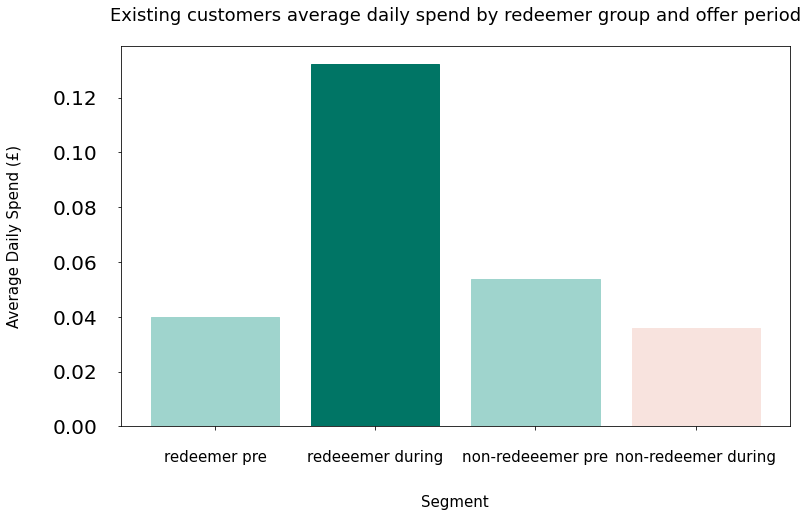

In [61]:
#quick plot of difference to help understanding
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7))
rp = pre_spend_daily['total_amount']['median']['redeemer']/100
rd = during_spend_daily['total_amount']['median']['redeemer']/100
nrp = pre_spend_daily['total_amount']['median']['non-redeemer']/100
nrd = during_spend_daily['total_amount']['median']['non-redeemer']/100
x = ['redeemer pre','redeeemer during','non-redeeemer pre','non-redeemer during']
y = pd.Series([rp,rd,nrp,nrd])

chart = plt.bar(x,y)
chart[0].set_color('mint')
chart[1].set_color('green')
chart[2].set_color('mint')
chart[3].set_color('pink')
plt.title('Existing customers average daily spend by redeemer group and offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)
plt.show()

- *Is the difference significant?*



### New customers (2+ transactions)
- This is a comparison in revenue impact between the new customers that redemeed the offer and new customers that did not redeem the offer
- We are only considering new customers with 2+ transactions because acquisition value is taken into consideration separately. 
- Comparing all of the new non-redeemers with just the new non-acquisisition redeemers, we are already selecting only redeemers with 2+ transactions (otherwise they would be acquisition redeemers)
- Who are the customers that were new in offer period and made 2+ transactions? How many are there?

In [154]:
new_cust_2plus = df_live[(df_live.new_existing=='new')&(df_live['receipt_count']>=2)].customer_id.unique()

- How many days were the new customers live for during our offer period by redemption segment?

In [169]:
#when did the customers first transact in the offer period
new_cust_first_txn = df_live[(df_live.customer_id.isin(new_cust_2plus))&(df_live['receipt_count']==1)][['customer_id','date','redemption_segment']].copy()
#how many days active were they
new_cust_first_txn['days_active'] = (date_max - new_cust_first_txn['date']).astype('timedelta64[D]')
#what is the average active days for new customers in each redemption group 
new_days_active = new_cust_first_txn.groupby('redemption_segment').agg({'days_active':['mean','median'],'customer_id':['nunique']})

In [170]:
new_days_active

days_active        customer_id
                          mean median     nunique
redemption_segment                               
non-redeemer        364.412436  416.0        1059
redeemer            324.649123  386.0          55

- How much did the new customers spend during the offer live period? Split by redemption group

In [175]:
during_spend_new = agg[agg.customer_id.isin(new_cust_2plus)].groupby('redemption_segment').agg({'total_amount':['mean','median','sum'],'customer_id':['nunique']})

In [176]:
during_spend_new

total_amount                    customer_id
                            mean  median        sum     nunique
redemption_segment                                             
non-redeemer         3567.668555  2232.0  3778161.0        1059
redeemer            10968.254545  6244.0   603254.0          55

- How much spend in this per day, considering how many days they were active for during offer live period (convert to £)?

In [182]:
daily_avg_spend_new = (during_spend_new['total_amount']['median']/new_days_active['days_active']['median'])/100
pd.DataFrame(daily_avg_spend_new)

,median
redemption_segment,
non-redeemer,0.053654
redeemer,0.161762


- What is the incremental daily spend between new redeemer and new non-redeemers?

In [183]:
daily_incr_new = (daily_avg_spend_new['redeemer'] - daily_avg_spend_new['non-redeemer'])
daily_incr_new

0.10810781187724193

- What does this total over a 60 days period of customer spend?

In [226]:
incr_spend_new = daily_incr_new*new_redeemers*60
incr_spend_new

428.106935033878

- How many redeemers are in this group?

In [227]:
#grab the numer of redeemers in 2+ category
new_cust_2plus_count = new_days_active.loc['redeemer'].customer_id.values[0]

- Print results for easy reading

In [228]:
print(f'For new customers, daily average incremetal spend was £{daily_incr_new:.2f} in the redeemer group')
print(f'')
print(f'Over the offer measurement period of {60} days, this is a total incremental spend of £{incr_spend_new:.2f} across the {new_cust_2plus_count:.0f} redeemers')
print(f'Or £{incr_spend_new/new_cust_2plus_count:.2f} per customer')

For new customers, daily average incremetal spend was £0.11 in the redeemer group

Over the offer measurement period of 60 days, this is a total incremental spend of £428.11 across the 55 redeemers
Or £7.78 per customer


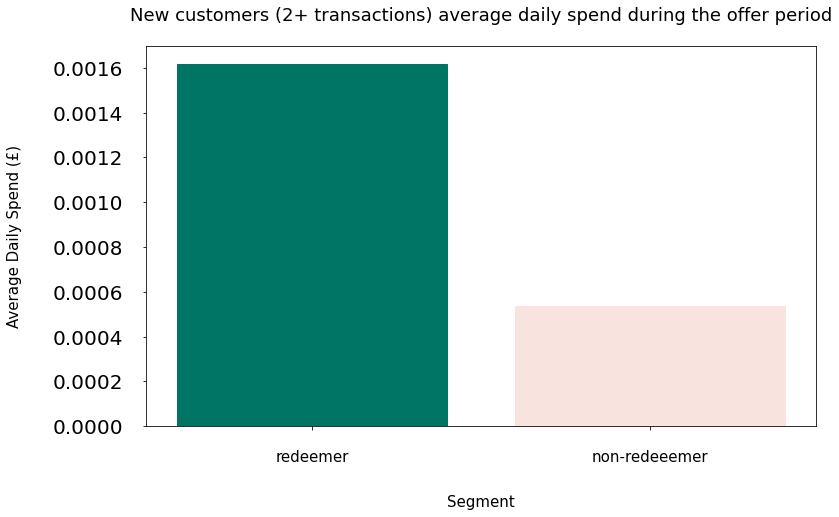

In [229]:
#quick plot of difference to help understanding

plt.figure(figsize = (12,7))
rd = daily_avg_spend_new['redeemer']/100
nrd = daily_avg_spend_new['non-redeemer']/100
x = ['redeemer','non-redeeemer']
y = pd.Series([rd,nrd])

chart = plt.bar(x,y)
chart[0].set_color('green')
chart[1].set_color('pink')
plt.title('New customers (2+ transactions) average daily spend during the offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)

plt.show()

## Acquired customers
spend of acquired customers over measurement period

- for the acquired customers, what was the date of their first transaction
- how many days over the offer period were they active (i.e. how many days after their first transaction)?


In [230]:
acquired = agg[agg['acquired_previous']=='acquired']
acquired_count = acquired.customer_id.nunique()
first_date = pd.DataFrame(df_live[df_live['acquired_previous']=='acquired'].groupby('customer_id').date.min())
acquired_df = pd.merge(acquired,first_date, on = 'customer_id', how = 'left')
acquired_df['max_date'] = date_max
acquired_df['date_diff'] = (new_df.max_date - new_df.date).dt.days
aquisition_avg_spend_daily = ((acquired_df['total_amount']/acquired_df['date_diff'])).median()/100
#what is this over a projected customer lifecycle for the retailer, use 90 days for now:
aquisition_avg_spend_projected = aquisition_avg_spend_daily*60
#what is this in total for the volume of acquisition customers?
aquisition_total_spend_projected = aquisition_avg_spend_projected*acquired_count

print(aquisition_avg_spend_daily)
print(aquisition_avg_spend_projected)
print(aquisition_total_spend_projected)

0.05625827553593947
3.3754965321563684
74.2609237074401


In [231]:
during_spend_acquired = agg[agg['acquired_previous']=='acquired']['total_amount'].sum()
acquired_cust = agg[agg['acquired_previous']=='acquired'].nunique()['customer_id']

print(f'For aquired customers, all spend is attributed to the offer')
print(f'Assumption is that the offer drove them to start transacting with the retailer')
print('\n')
print(f'Over the projected customer lifecycle of 60 days, this is a total spend of £{aquisition_total_spend_projected:.2f} across the {acquired_count:.0f} customers')
print(f'Or £{aquisition_avg_spend_projected:.2f} per customer')
print(f'Or £{aquisition_avg_spend_daily:.2f} per customer per day')

For aquired customers, all spend is attributed to the offer
Assumption is that the offer drove them to start transacting with the retailer


Over the projected customer lifecycle of 60 days, this is a total spend of £74.26 across the 22 customers
Or £3.38 per customer
Or £0.06 per customer per day


### Note:
- above acquisition method doesn't take into account the 'slowing down' of spend when making a spend projection over X days
- this may need changing as for short offers, will assume spend over longer period of time will maintain the same level as when the customer first joins and is mmore engaged, likely to fall in reality
- instead could look at spend from acquired 30 days after their first transaction and project LTV based on that value per customer
- this is moving into the customer segment predictions we want to do so will wait until I get to that to amend method.


### Revenue impact for previous customers (Existing + New)

In [238]:
previous_revenue = incr_spend_new + incr_spend_existing 
previous_revenue_avg = previous_revenue/(exisiting_redeemers+new_cust_2plus_count)

print(f'The total incremental revenue from this offer over the measurement period is £{previous_revenue:.0f}')
print(f'Per redeemer this is £{previous_revenue_avg:.2f}')

The total incremental revenue from this offer over the measurement period is £1004
Per redeemer this is £6.88


### Cost for previous customers

In [239]:
previous_redeemer_receipts = df_live[(df_live.acquired_previous.isin(['previous']))&(df_live.redemption_segment.isin(['redeemer']))]['receipt_id'].unique()

previous_cost = (df_offer[df_offer['receipt_id'].isin(previous_redeemer_receipts)]['price']*-1).sum()/100
previous_cost_avg = previous_cost/(exisiting_redeemers+new_cust_2plus_count)

print(f'The total discount given out over the offer measurement period is £{previous_cost}')
print(f'Per redeemer this is £{previous_cost_avg:.2f}')

The total discount given out over the offer measurement period is £782.9
Per redeemer this is £5.36


### ROI for previous customers

In [242]:
roi_previous = previous_revenue_avg/previous_cost_avg
roi_previous

1.2829129893521203

# *** Tidied up to here ***

### Revenue impact for acquired customers 

In [ ]:
revenue_

### Cost for acquired

In [ ]:
#cost for acquired:
redeemer_receipts_during = df_during[df_during['new_segment'] == 'acquired']['receipt_id'].unique()

total_cost_acq = (df_off[df_off['receipt_id'].isin(redeemer_receipts_during)]['price']*-1).sum()/100
total_cost_cust_acq = total_cost/total_cust

print(f'The total discount given out over the offer measurement period is £{total_cost}')
print(f'Per redeemer this is £{total_cost_cust:.2f}')

# ROI acquired only

In [ ]:
print(f'Acquired customers monthly revenue is £{roi_monthly_total:.2f}')
print(f'Acquired customers cost is £{total_cost_acq:.2f}')

print((roi_monthly_total - total_cost_acq))

ROI_acq = (roi_monthly_total/total_cost_acq)
print(f'Return on investment is {ROI_acq:.2f}')

## ROI not acquired

In [ ]:
ROI = (total_incr_rev/total_cost)


print((total_incr_rev - total_cost))

print(f'Previous customers monthly increase in revenue is £{total_incr_rev:.2f}')
print(f'Previous customers cost is £{total_cost:.2f}')
print(f'Return on investment is {ROI:.2f}')

## ATV

In [ ]:
v_metrics = agg2['ATV']

agg
ATV_redeemer = agg[agg['offer_segment']=='redeemer']['amount'].median()/100
ATV_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['amount'].median()/100

print(f'Redeemers have an average transaction value of £{ATV_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average transaction value of £{ATV_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of ATV:')
print(v_metrics)
print('\n')

In [ ]:
#average transaction value of redemmers total is :
agg[agg['offer_segment']=='redeemer']['amount'].median()/100

In [ ]:
agg['prev_segment']= np.where(agg['new_segment'].isin(['existing','new']),'previous','acquired')

In [ ]:
agg3 = agg.groupby(['offer_segment','prev_segment']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'adjusted_basket_size':['mean','median']
                                                                           })

In [ ]:
#£ ATV for previosu vs acquired
agg3.loc['redeemer']['amount']['median']/100

In [ ]:
agg3.loc['redeemer']['customer_id']['nunique']/(agg3.loc['redeemer']['customer_id']['nunique'].sum())

## Basket Size

In [ ]:
#now can summarise by segments the average basket size 
b_metrics = agg2['ABS']

ABS_redeemer = agg[agg['offer_segment']=='redeemer']['adjusted_basket_size'].median()
ABS_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['adjusted_basket_size'].median()

print('Excluding the item on offer from the basket:')
print(f'Redeemers have an average basket size of {ABS_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average basket size of {ABS_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of Basket Size:')
print(b_metrics)
print('\n')

## Time of Day/ Day of Week Redemption

In [ ]:
df_during['weekday_name'] = df_during['transaction_date'].dt.day_name()
df_during['weekday'] = df_during['transaction_date'].dt.weekday
df_during['time_hour'] = df_during['transaction_date'].dt.hour

In [ ]:
days = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['weekday','weekday_name']).nunique()['receipt_id'])
days.columns = ['unique_receipts']
days.reset_index('weekday', drop = True, inplace = True)
top_day = days.sort_values(by = 'unique_receipts',ascending = False).head(1)
print(f'Overall, the most popular day to redeem is {top_day.index.values[0]}')

In [ ]:
#split by new and existing redeemers
days_seg = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['new_segment','weekday','weekday_name']).nunique()['receipt_id'])
days_seg.columns = ['unique_receipts']
days_seg.reset_index('weekday', drop = True, inplace = True)
top_day_existing = days_seg.loc['existing'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_day_new = days_seg.loc['new'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_day_acquired = days_seg.loc['acquired'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
print(f'The most popular day for existing customers is {top_day_existing}')
print(f'The most popular day for new customers is {top_day_new}')
print(f'The most popular day for acquired customers is {top_day_acquired}')

In [ ]:
matplotlib.rcParams['xtick.labelsize'] = '30'
matplotlib.rcParams['ytick.labelsize'] = '30'



x = days.index.values
y = days['unique_receipts']
plt.bar(x,y,color = 'mint')
plt.title('Offer redemptions by day of week', size = 40)
plt.show()

In [ ]:
x1 = days_seg.loc['existing'].index.values
y1 = ((days_seg.loc['existing']/days_seg.loc['existing'].sum())*100)['unique_receipts']
x2 = days_seg.loc['new'].index.values
y2 = ((days_seg.loc['new']/days_seg.loc['new'].sum())*100)['unique_receipts']
x3 = days_seg.loc['acquired'].index.values
y3 = ((days_seg.loc['acquired']/days_seg.loc['acquired'].sum())*100)['unique_receipts']
plt.plot(x1,y1,color = 'mint', label = 'existing',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x2,y2,color = 'green', label = 'new',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x3,y3,color = 'black', label = 'acquired',marker='o', linestyle='dashed',linewidth=2, markersize=12)
#plt.title('Offer redemptions by day of week and segment', size = 40, pad = 10)
plt.legend(fontsize = 30)
plt.ylabel('% of segment receipts', size = 30)
plt.show()

In [ ]:
hours = df_during[df_during['redemption_count']>0].groupby(['time_hour']).nunique()['receipt_id']

In [ ]:
hours.columns = ['unique_receipts']
top_hour = hours.sort_values(ascending = False).head(1)
print(f'The most popular hour is {top_hour.index.values[0]}')

In [ ]:
matplotlib.rcParams['xtick.labelsize'] = '30'
matplotlib.rcParams['ytick.labelsize'] = '30'

x = hours.index.values
y = hours
plt.bar(x,y,color = 'tmnt')
plt.title('Offer redemptions by hour', size = 40)
plt.show()

In [ ]:
#split by new and existing redeemers
hours_seg = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['new_segment','time_hour']).nunique()['receipt_id'])
hours_seg.columns = ['unique_receipts']
top_hour_existing = hours_seg.loc['existing'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_hour_new = hours_seg.loc['new'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_hour_acq = hours_seg.loc['acquired'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]

print(f'The most popular hour of day for existing customers is {top_hour_existing}')
print(f'The most popular hour of day for new customers is {top_hour_new}')
print(f'The most popular hour of day for new customers is {top_hour_acq}')

In [ ]:
x1 = hours_seg.loc['existing'].index.values
y1 = ((hours_seg.loc['existing']/hours_seg.loc['existing'].sum())*100)['unique_receipts']
x2 = hours_seg.loc['new'].index.values
y2 = ((hours_seg.loc['new']/hours_seg.loc['new'].sum())*100)['unique_receipts']
x3 = hours_seg.loc['acquired'].index.values
y3 = ((hours_seg.loc['acquired']/hours_seg.loc['acquired'].sum())*100)['unique_receipts']
plt.plot(x1,y1,color = 'mint', label = 'existing',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x2,y2,color = 'green', label = 'new',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x3,y3,color = 'black', label = 'acquired',marker='o', linestyle='dashed',linewidth=2, markersize=12)
#plt.title('Offer redemptions by day of week and segment', size = 40, pad = 10)
plt.legend(fontsize = 30)
plt.ylabel('% of segment receipts', size = 30)
plt.show()

In [ ]:
#matrix of day and hour

day_hours = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['weekday','weekday_name','time_hour']).nunique()['receipt_id'])
day_hours.columns =['unique_receipts']
#day_hours.reset_index('weekday',drop=True,inplace = True)
day_hours_unstack = day_hours.unstack().fillna(0)
day_hours_unstack.reset_index('weekday',drop=True,inplace = True)

In [ ]:
day_hours_unstack.style.background_gradient(cmap='BuGn', axis = None).set_precision(0)

## Repeat Redemptions
### Offer Repeat Rate
    - new
    - existing
    - by timeframe (e.g. day, week, month depending on length of offer)

In [ ]:
repeat_reds = pd.DataFrame(df_during[df_during.receipt_id.isin(off_receipts)].groupby(['new_segment','customer_id'])['receipt_id'].nunique().reset_index())

In [ ]:
repeat_reds.groupby('new_segment').count()

In [ ]:


existing_redeemers = repeat_reds[repeat_reds['new_segment']=='existing']['customer_id'].nunique()
rep_existing_redeemers = repeat_reds[(repeat_reds['new_segment']=='existing') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

new_redeemers = repeat_reds[repeat_reds['new_segment']=='new']['customer_id'].nunique()
rep_new_redeemers = repeat_reds[(repeat_reds['new_segment']=='new') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

acq_redeemers = repeat_reds[repeat_reds['new_segment']=='acquired']['customer_id'].nunique()
rep_acq_redeemers = repeat_reds[(repeat_reds['new_segment']=='acquired') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

pcent_existing = (rep_existing_redeemers/existing_redeemers)*100
pcent_new = (rep_new_redeemers/new_redeemers)*100
pcent_acq = (rep_acq_redeemers/acq_redeemers)*100

print(f'A total of {len(off_receipts)} redemptions were made on the offer')
print('\n')
print(f'The percentage of existing redeemers that made more than 1 redemption is {pcent_existing:.2f}% ({rep_existing_redeemers}/{existing_redeemers})')
print(f'The percentage of new redeemers that made more than 1 redemption is {pcent_new:.2f}% ({rep_new_redeemers}/{new_redeemers})')
print(f'The percentage of acquired redeemers that made more than 1 redemption is {pcent_acq:.2f}% ({rep_acq_redeemers}/{acq_redeemers})')

# ***Post offer analysis***:

- Long-term impact on frequency of customers redeeming the offer
    - Time series data
    - vs non-redeemers
- Long term impact of ATV of customers redeeming the offer
    - vs non-redeemers
- Retention of customers who have redeemed the offer vs baseline
- Segment of customers acquired via the offer
    - % in each segment vs expected %

In [ ]:
redemption_segment = agg[['offer_segment','customer_id']]
df_red_seg = pd.merge(df,redemption_segment, on = 'customer_id',how = 'left')

In [ ]:
df_red_seg['offer_segment'] = df_red_seg['offer_segment'].fillna('non-redeemer')

In [ ]:
df_red_seg.head()

In [ ]:
df_red_seg.groupby(['customer_id').